In [1]:
import os
import sys
import pandas as pd
import re


In [2]:
test_df = pd.read_csv('../../data/spanish/test.csv')
train_df = pd.read_csv('../../data/spanish/train.csv')
val_df = pd.read_csv('../../data/spanish/valid.csv')


test_df.head()

,text,label,source
0,"@user jajajaja dale, hacete la boluda vos jaja...",negative,intertass_2017
1,cada vez que cito un tweet se va la ubicación ...,neutral,intertass_2017
2,@user MAAAAE RAJADO! Pero lo bueno es q uno se...,positive,intertass_2017
3,Bueno hoy fui a almorzar a Nanay con otras 3 d...,negative,intertass_2017
4,Necesito seguir a mas cuentas camren shippers ...,neutral,intertass_2017


In [3]:
# from sklearn.model_selection import train_test_split

# train_df, _ = train_test_split(
#     train_df,
#     test_size = 0.6 ,
#     stratify = train_df['label'],
#     random_state = 42
# )

In [4]:
train_df = train_df[train_df["label"] != "neutral"]
test_df  = test_df[test_df["label"]  != "neutral"]
val_df   = val_df[val_df["label"]   != "neutral"]

mapping = {'negative': 0, 'positive': 1}

train_df['sentiment_num'] = train_df['label'].map(mapping)
test_df['sentiment_num'] = test_df['label'].map(mapping)
val_df['sentiment_num'] = val_df['label'].map(mapping)

In [5]:
url_pattern = re.compile(r"http\S+|www\.\S+")
mention_pattern = re.compile(r"@\w+")
hashtag_pattern = re.compile(r"#(\w+)")
rt_pattern = re.compile(r"^RT\s+@\w+:\s*")

def normalize_elongation(word, max_repeat=2):
    return re.sub(r"(.)\1{"+str(max_repeat)+r",}", r"\1"*max_repeat, word)

def clean_tweet(text: str) -> str:
    if not isinstance(text, str):
        return ""
    
    text = rt_pattern.sub("", text)
    text = url_pattern.sub(" URL ", text)
    text = mention_pattern.sub(" @usuario ", text)
    text = hashtag_pattern.sub(r"\1", text)
    text = re.sub(r"\s+", " ", text).strip()
    text = text.lower()
    tokens = []
    for tok in text.split():
        tokens.append(normalize_elongation(tok))
    text = " ".join(tokens)

    return text



train_df["clean_text"] = train_df["text"].apply(clean_tweet)
test_df["clean_text"] = test_df["text"].apply(clean_tweet)
val_df["clean_text"] = val_df["text"].apply(clean_tweet)

In [6]:
import torch

from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, AdamW, XLMRobertaTokenizerFast, XLMRobertaForSequenceClassification
from datasets import Dataset

model_name = "xlm-roberta-base"
tok = XLMRobertaTokenizerFast.from_pretrained(model_name)

MAX_LEN = 128  
def tokenize(batch):
    return tok(
        batch["text"].tolist(),
        padding="max_length",
        truncation=True,
        max_length=MAX_LEN,
        return_tensors="pt"
    )

train_encodings = tokenize(train_df)
val_encodings = tokenize(val_df)
test_encodings = tokenize(test_df)


/opt/miniconda3/envs/mbertproj/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/miniconda3/envs/mbertproj/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_dataset = SentimentDataset(train_encodings, train_df["sentiment_num"].values)
val_dataset = SentimentDataset(val_encodings, val_df["sentiment_num"].values)
test_dataset = SentimentDataset(test_encodings, val_df["sentiment_num"].values)

In [8]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, shuffle = True, batch_size = 8)
#change number of labels based on keep/drop neutral class

label2id = {
    "negative": 0,
    "positive": 1,
}

id2label = {v: k for k, v in label2id.items()}

num_labels = len(label2id)
model = XLMRobertaForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)
training_args = TrainingArguments(
    output_dir="results",
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

trainer.train()

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/miniconda3/envs/mbertproj/lib/python3.11/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 20%|██        | 77/385 [01:10<04:48,  1.07it/s]

{'loss': 0.6559, 'grad_norm': 11.753073692321777, 'learning_rate': 1.6000000000000003e-05, 'epoch': 1.0}


                                                
 20%|██        | 77/385 [01:13<04:48,  1.07it/s]

{'eval_loss': 0.5010708570480347, 'eval_runtime': 3.4051, 'eval_samples_per_second': 63.435, 'eval_steps_per_second': 4.111, 'epoch': 1.0}


 40%|████      | 154/385 [02:27<03:54,  1.02s/it]

{'loss': 0.4664, 'grad_norm': 30.340246200561523, 'learning_rate': 1.2e-05, 'epoch': 2.0}


                                                 
 40%|████      | 154/385 [02:31<03:54,  1.02s/it]

{'eval_loss': 0.386861652135849, 'eval_runtime': 3.4814, 'eval_samples_per_second': 62.044, 'eval_steps_per_second': 4.021, 'epoch': 2.0}


 60%|██████    | 231/385 [04:16<03:54,  1.52s/it]

{'loss': 0.365, 'grad_norm': 32.95154571533203, 'learning_rate': 8.000000000000001e-06, 'epoch': 3.0}


                                                 
 60%|██████    | 231/385 [04:20<03:54,  1.52s/it]

{'eval_loss': 0.41696012020111084, 'eval_runtime': 4.4886, 'eval_samples_per_second': 48.122, 'eval_steps_per_second': 3.119, 'epoch': 3.0}


 80%|████████  | 308/385 [06:00<01:43,  1.35s/it]

{'loss': 0.2729, 'grad_norm': 2.600358724594116, 'learning_rate': 4.000000000000001e-06, 'epoch': 4.0}


                                                 
 80%|████████  | 308/385 [06:05<01:43,  1.35s/it]

{'eval_loss': 0.3522223234176636, 'eval_runtime': 4.5067, 'eval_samples_per_second': 47.928, 'eval_steps_per_second': 3.106, 'epoch': 4.0}


100%|██████████| 385/385 [08:04<00:00,  1.24s/it]

{'loss': 0.224, 'grad_norm': 35.37046432495117, 'learning_rate': 0.0, 'epoch': 5.0}


                                                 
100%|██████████| 385/385 [08:06<00:00,  1.24s/it]

{'eval_loss': 0.3772035539150238, 'eval_runtime': 2.6954, 'eval_samples_per_second': 80.138, 'eval_steps_per_second': 5.194, 'epoch': 5.0}


100%|██████████| 385/385 [08:09<00:00,  1.27s/it]

{'train_runtime': 489.7147, 'train_samples_per_second': 12.517, 'train_steps_per_second': 0.786, 'train_loss': 0.3968362436666117, 'epoch': 5.0}


TrainOutput(global_step=385, training_loss=0.3968362436666117, metrics={'train_runtime': 489.7147, 'train_samples_per_second': 12.517, 'train_steps_per_second': 0.786, 'total_flos': 403217692339200.0, 'train_loss': 0.3968362436666117, 'epoch': 5.0})

In [9]:
metrics = trainer.evaluate()
print(metrics)

100%|██████████| 14/14 [00:02<00:00,  5.16it/s]

{'eval_loss': 0.3772035539150238, 'eval_runtime': 2.7287, 'eval_samples_per_second': 79.159, 'eval_steps_per_second': 5.131, 'epoch': 5.0}


In [10]:
predictions = trainer.predict(val_dataset)

100%|██████████| 14/14 [00:03<00:00,  3.74it/s]


In [11]:
import numpy as np

from sklearn.metrics import accuracy_score, f1_score, classification_report

logits = predictions.predictions      # or predictions[0]
labels = predictions.label_ids        # or predictions[1]

y_pred = np.argmax(logits, axis=-1)

print("Accuracy:", accuracy_score(labels, y_pred))
print("F1 (macro):", f1_score(labels, y_pred, average="macro"))

print(
    classification_report(
        labels,
        y_pred,
        #target_names=["negative", "neutral", "positive"]
        target_names=["negative","positive"]
    )
)

Accuracy: 0.8888888888888888
F1 (macro): 0.8886502276827906
              precision    recall  f1-score   support

    negative       0.93      0.84      0.88       108
    positive       0.86      0.94      0.89       108

    accuracy                           0.89       216
   macro avg       0.89      0.89      0.89       216
weighted avg       0.89      0.89      0.89       216



Test Dataset

In [12]:
pred = trainer.predict(test_dataset)
y_true = test_df["sentiment_num"]
y_pred = np.argmax(pred.predictions, axis=1)


logits = pred.predictions   
labels = pred.label_ids   


print("Accuracy:", accuracy_score(labels, y_pred))
print("F1 (macro):", f1_score(labels, y_pred, average="macro"))

print(
    classification_report(
        labels,
        y_pred,
        #target_names=["negative", "neutral", "positive"]
        target_names=["negative","positive"]
    )
)

100%|██████████| 14/14 [00:03<00:00,  4.42it/s]


Accuracy: 0.8240740740740741
F1 (macro): 0.8240137221269297
              precision    recall  f1-score   support

    negative       0.84      0.81      0.82       108
    positive       0.81      0.84      0.83       108

    accuracy                           0.82       216
   macro avg       0.82      0.82      0.82       216
weighted avg       0.82      0.82      0.82       216



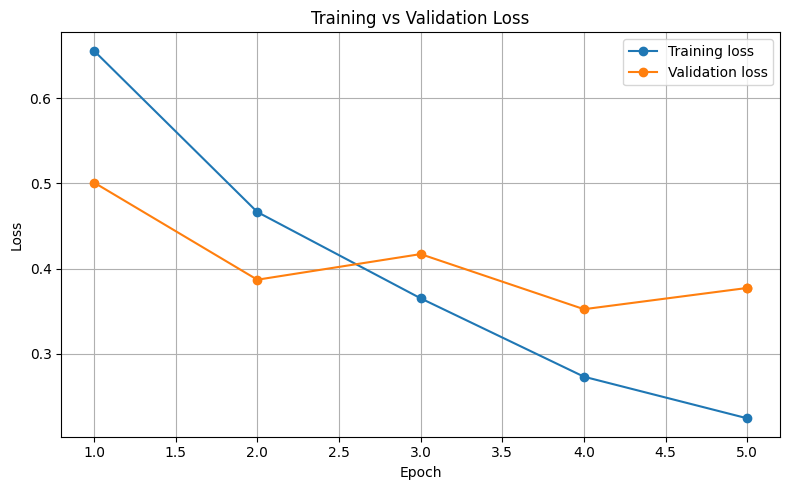

In [13]:
import matplotlib.pyplot as plt

# After training:
# trainer.train()

logs = pd.DataFrame(trainer.state.log_history)

# Separate train and eval logs
train_logs = logs[logs["loss"].notna()][["epoch", "loss"]]
eval_logs  = logs[logs["eval_loss"].notna()][["epoch", "eval_loss"]]

plt.figure(figsize=(8, 5))

plt.plot(train_logs["epoch"], train_logs["loss"], marker="o", label="Training loss")
plt.plot(eval_logs["epoch"], eval_logs["eval_loss"], marker="o", label="Validation loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()